<a href="https://colab.research.google.com/github/Drisnor/M1-Semestre-7-MCS/blob/main/TP1_3MCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  TP  MCS  1 à 3  : Reconnaissance de commandes audio par DTW

**Nom du Groupe :**
Les worlds

**Noms :**
AMALRIC
GIMENEZ 
SAULIERES

**Prénoms :**
Antoine
Florent
Léo

**Parcours :**
IARF x3

Ces trois séances de TP (2 séances encadrées et une non encadrée) vont vous permettre de tester l'algorithme de programmation dynamique vu en
TD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).



Ces séances se décomposent en 3 parties : 
- Partie I : DTW et application du TD
- Partie II : Système de reconnaissance audio de mots de commande
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Pour les **parties II et III**, vous testerez le système de reconnaissance audio sur deux corpus de voix qui serviront respectivement de base d'apprentissage (références) et de base de test (sons à reconnaître) que vous choisirez. La liste des 13 commandes au drone sont : *Atterrissage, Décollage, Avance, Tourne droite, Recule, Tourne gauche, Droite, Fais un flip, Gauche, Arrête toi, plus haut, plus bas et Etat d'urgence.*



Pour cela, vous devez par groupe de **3 étudiants** (effectif **OBLIGATOIRE**):
1. **Proposer une étude** que vous détaillerez sur un rapport
[par exemple, *influence voix masculines VS voix féminines, confronter vos propres voix à la base de données, tester l'impact de différents bruits de fond sur la reconnaissance...*];
2. Créer, en fonction de l'objectif de votre étude, vos propres base d'apprentissage et base de test à partir du corpus proposé et des voix et bruits que vous aurez enregistrés [*paramètres audio : 16 KHz, mono, 16 bits, format *.wav**];
3. Tester la DTW et une méthode de classification avec prétraitement par ACP;
4. Evaluer les résultats; 
5. Rédiger un rapport en pdf présentant l'étude, les résultats par les 2 méthodes et vos commentaires et conclusions sur votre étude (Longueur max. : 5 pages).

In [ ]:
import matplotlib.pyplot as plt
from numpy import array, zeros, full, argmin, inf, ndim
import scipy
import sklearn
import math

# Partie I : Implémentation de l'algorithme de programmation dynamique 


1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 

2. Afin d'adapter facilement le calcul des coûts suivant la nature des données (et donc des distances utilisées), écrivez une fonction pour chaque distance (euclidienne, lettres, sons) qui apparaîtra en paramètre de la fonction DTW.

In [ ]:
# --------------------------------------------------
# BLOC qui regroupe les fonctions pour les distances
# --------------------------------------------------
# -*- coding: utf-8 -*-
import numpy as np

distSons = [[0,1,1,1,2], 
            [1,0,1,1,2],
            [1,1,0,1,1],
            [1,1,1,0,2],
            [2,2,1,2,0]
           ]

listeSons = ['X', 'C', 'U', 'Ux', 'V']

# Distance entre séquences numériques
def euclidienne(i, j):
  return abs(i-j)

# Distance entre séquences d'ADN
def lettres(i, j):
  if i == j :
    return 0
  #else
  return 1

# Distance entre 2 signaux sonores
def sons(i, j):
  return distSons[listeSons.index(i)] [listeSons.index(j)]

def distVect(A,B):
  somme = 0;
  for i in range(len(A)):
    somme += (A[i]-B[i])**2
  return round(np.sqrt(somme),2)

In [ ]:
# ----------------------------------------------------
# BLOC qui recherche le chemin minimal à la fin du DTW
# ----------------------------------------------------
# Retrouve récursivement le chemin minimal à partir de la matrice construite
# (avec des 1, 2 et 3) prévus pour retrouver le chemin
def trouveCheminMin(matChemin, i, j, L) :
  # condition d'arrêt
  # on a volontairement mis -1 dans g[0][0]
  if matChemin[i][j] == -1 :
    return L
  
  #else
  # on vient de la gauche
  if matChemin[i][j] == 1 : 
    L.append((i, j-1))  # coords de la case de gauche
    trouveCheminMin(matChemin, i, j-1, L)
  # on vient de la diag
  elif matChemin[i][j] == 2 :
    L.append((i-1, j-1))  # coords de la case de la diag
    trouveCheminMin(matChemin, i-1, j-1, L)
  # on vient du dessus
  elif matChemin[i][j] == 3 :
    L.append((i-1, j))  # coords du dessus
    trouveCheminMin(matChemin, i-1, j, L)

In [ ]:
def DTW(seq1, seq2, w0, w1, w2, fonctionDist, typeDonnees) :
  if typeDonnees== "M":
    # on transpose pour accéder plus facilement aux colonnes sans changer le code
    X = np.transpose(seq1)
    Y = np.transpose(seq2)
    # la taille de la liste est donc maintenant le nombre de colonnes
    I = len(X)+1
    J = len(Y)+1
  else:
    X = np.array(seq1)  # transforme en vecteur
    Y = np.array(seq2)  # transforme en vecteur
    I = len(seq1)+1
    J = len(seq2)+1

  matChemin = np.zeros((I, J))  # pour retrouver le chemin minimal
  matChemin[0][0] = -1  # condition d'arrêt de la recherche du chemin minimal
  g = np.zeros((I, J))  # matrice nulle

  for j in range(1, J): 
    g[0][j] = np.inf
  
  for i in range(1, I):
    g[i][0] = np.inf
    
    for j in range(1, J):
      # On précise si c'est un ADN ou pas
      # contraintes de non calcul pour l'ADN UNIQUEMENT
      if typeDonnees=="ADN" and (i>j+4 or j>i+4) :  
        g[i][j] = np.inf
      else :
        # recherche du chemin minimal
        dist = fonctionDist(X[i-1], Y[j-1])

        # On récupère d'où l'on vient (le min)
        haut = g[i-1][j]   + w0*dist
        diag = g[i-1][j-1] + w1*dist
        gauche = g[i][j-1] + w2*dist
        g[i][j] = min(gauche, diag, haut)

        # Ajoute une valeur en fonction d'où on vient
        if typeDonnees=="M":
          if g[i][j] == gauche :
            matChemin[i][j] = 1  # on vient de la gauche
          elif g[i][j] == diag :
            matChemin[i][j] = 2  # on vient de la diag
          elif g[i][j] == haut :
            matChemin[i][j] = 3 # on vient du dessus

  D = round(g[I-1][J-1]/((I+J)-2),2)
  # On lance la recherche du chemin minimal
  # on met la liste [] qui contiendra les des couples des elements du chemin min
  if typeDonnees!="M":
    listeCouples = [(i,j)]
    trouveCheminMin(matChemin, i, j, listeCouples)  # on ne prend pas en compte les colonnes ajoutées infinies 
    print("matChemin = \n", np.matrix(matChemin))
    print("g = \n", np.matrix(g))
    print("D = ", D)
  else :
    return D

In [ ]:
#####################################################################
########################## TESTS ##########################
#####################################################################

w0, w1, w2 = 1, 1, 1

# Séquence numérique
print("Numérique :")
DTW( (3, -13, 14, -7, 9, -2)
    , (-2, 10, -10, 15, -13, 20, -5, 14, 2)
    , w0, w1, w2, euclidienne, False)

print("\n-------------------------------------")
# Séquence d'ADN
print("\nADN :")
DTW( ('A', 'A', 'G', 'T', 'A', 'G', 'G', 'C')
     , ('A', 'T', 'G', 'G', 'T', 'A', 'C', 'G', 'T', 'C')
     , w0, w1, w2, lettres, True)


Numérique :
matChemin = 
 [[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
g = 
 [[  0.  inf  inf  inf  inf  inf  inf  inf  inf  inf]
 [ inf   5.  12.  25.  37.  53.  70.  78.  89.  90.]
 [ inf  16.  28.  15.  43.  37.  70.  78. 105. 104.]
 [ inf  32.  20.  39.  16.  43.  43.  62.  62.  74.]
 [ inf  37.  37.  23.  38.  22.  49.  45.  66.  71.]
 [ inf  48.  38.  42.  29.  44.  33.  47.  50.  57.]
 [ inf  48.  50.  46.  46.  40.  55.  36.  52.  54.]]
D =  3.6

-------------------------------------

ADN :
matChemin = 
 [[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.

In [ ]:
#####################################################################
########################## Signaux sonores ##########################
# On change les poids pour les sons
w0, w1, w2 = 1, 2, 1
print("\n-------------------------------------")
print("\nSonores avec tous les mots de référence : ")
cinq  = ('X', 'V', 'V', 'C', 'X')
vingt = ('Ux', 'V', 'V')
cent  = ('X', 'V', 'V') 
mot1 = ('X', 'X', 'V', 'U', 'X', 'C', 'X')
mot2 = ('Ux', 'Ux', 'V', 'X', 'X', 'V', 'Ux', 'X', 'X', 'V')

print("\nComparaison de " + ''.join(cinq) + " et " + ''.join(mot1))
DTW( mot1
     , cinq
     , w0, w1, w2, sons, False)

print("\nComparaison de " + ''.join(vingt) + " et " + ''.join(mot1))
DTW( mot1
     , vingt
     , w0, w1, w2, sons, False)

print("\nComparaison de " + ''.join(cent) + " et " + ''.join(mot1))
DTW( mot1
     , cent
     , w0, w1, w2, sons, False)

print("\n-------------------------------------")
print("\nComparaison de " + ''.join(cinq) + " et " + ''.join(mot2))
DTW( mot2
     , cinq
     , w0, w1, w2, sons, False)

print("\nComparaison de " + ''.join(vingt) + " et " + ''.join(mot2))
DTW( mot2
     , vingt
     , w0, w1, w2, sons, False)

print("\nComparaison de " + ''.join(cent) + " et " + ''.join(mot2))
DTW( mot2
     , cent
     , w0, w1, w2, sons, False)


-------------------------------------

Sonores avec tous les mots de référence : 

Comparaison de XVVCX et XXVUXCX
matChemin = 
 [[-1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
g = 
 [[ 0. inf inf inf inf inf]
 [inf  0.  2.  4.  5.  5.]
 [inf  0.  2.  4.  5.  5.]
 [inf  2.  0.  0.  2.  4.]
 [inf  3.  1.  1.  2.  3.]
 [inf  3.  3.  3.  3.  2.]
 [inf  4.  5.  5.  3.  3.]
 [inf  4.  6.  7.  4.  3.]]
D =  0.25

Comparaison de UxVV et XXVUXCX
matChemin = 
 [[-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
g = 
 [[ 0. inf inf inf]
 [inf  2.  4.  6.]
 [inf  3.  5.  7.]
 [inf  5.  3.  3.]
 [inf  6.  4.  4.]
 [inf  7.  6.  6.]
 [inf  8.  8.  8.]
 [inf  9. 10. 10.]]
D =  1.0

Comparaison de XVV et XXVUXCX
matChemin = 
 [[-1.  0

### Application aux exercices 

1. Testez vos programmes sur les exercices vus en TD. 

2. Modifiez les contraintes locales c'est-à-dire les pondérations suivant les directions. 

3. Ajoutez la prise en compte de contraintes globales c'est-à-dire le non calcul lorsque les cases sont trop éloignées de la diagonale (cf exercice TD séquence ADN). A partir de quelle position les contraintes globales ne changent pas les résultats ?

# Partie II :  Système de reconnaissance audio de mots de commande

Sur l'espace partagé, vous trouverez des enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05).

Vous pouvez diviser ainsi l'ensemble des données en base d'apprentissage qui serviront de références et base de test pour évaluer la reconnaissance par programmation dynamique.

In [ ]:
#https://www.youtube.com/watch?v=TqLmN6-6Lxc  Orages et pluie
#https://www.youtube.com/watch?v=XFmImkwBYP4  Vents
#https://www.youtube.com/watch?v=2I-42VEiX8A  Alarme incendie
#https://www.youtube.com/watch?v=7t2HZLZ1PQs  Applaudissements
#https://www.youtube.com/watch?v=x4gRqpGLsps  Traffic Routier
#https://www.youtube.com/watch?v=YbFLigVzbVw  Mitrailleuse
# Bande sonnore à utiliser comme bruit de fond pour les enregistrements

# Paramètre d'enregistrement :
# Sur Audacity : 16 KHz, mono, 16 bits, format .wav
# Pour l'expérience :
  # Enregistrement de l'ordre atterrissage, decollage, tournedroite et tournegauche
  # 3 enregistrements par bande sonore
  # pour chaque enregistrement -> son de la vidéo au max
  #                            -> 1 test : 10% capacité sonore du pc
  #                            -> 2 test : 20% capacité sonore du pc
  #                            -> 3 test : 40% capacité sonore du pc
  # ton de voix monotone

import librosa

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond à la dimension du vecteur représentatif : ici 12.

**Chargement d'un fichier audio :**

In [ ]:
from google.colab import drive
from scipy.io import wavfile  # pour le son
from IPython.display import Audio
import os
drive.mount('/content/drive/')

# Chargons tous les fichiers audio ici dans un tableau de couple ( y, sr )
repertory =  "/content/drive/My Drive/Colab Notebooks/corpus/dronevolant_nonbruite/"
LOADED = []
for audio in os.listdir(repertory):
  name_son = repertory+audio
  LOADED.append((audio,librosa.load(name_son)))

# Les elements de LOADED sont de la forme ( nom_du_fichier_audio, (y , sr) )
# Soit x l'indice d'un élement quelconque de notre BDD
# on récupère son nom avec LOADED[x][0]
# on récupère le y avec LOADED[x][1][0]  qui est l'attribut y = de la méthode librosa.feature.mfcc
# on reécupère le sr avec LOADED[x][1][1]  qui est l'attribut sr = de la méthode librosa.feature.mfcc


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Calcul des MFCC**

In [ ]:
#Petit test pour connaitre la taille la taille de nos MFCC
print("Notre son est : ", LOADED[1][0])
mfcc = librosa.feature.mfcc(y=LOADED[1][1][0], sr=LOADED[1][1][1], hop_length=1024, htk=True, n_mfcc=12)
print("Nb Coeff MFCC x Nb Fenetres :",mfcc.shape)
#plt.imshow(mfcc)

Notre son est :  F01_atterrissage.wav
Nb Coeff MFCC x Nb Fenetres : (12, 47)


**Application de la DTW**

1. Réaliser une étude que vous détaillerez sur un rapport (par exemple, *influence voix masculines VS voix féminines, confronter votre propre voix à la base de données, tester l'impact de différents bruits de fond sur la reconnaissance...*) et créer votre propre base d'apprentissage et votre base de test à partir du corpus et des voix et bruits que vous aurez enregistrés. 

2. Appliquer la DTW sur vos corpus.

**Paramètres pour enregistrements audio de vos voix perso:**

16 KHz, mono, 16 bits, format *.wav*

In [ ]:
# Une fonction d'affichage simplifié pour la correspondance dans la bdd
def tableur(X, Y, T):
  print(X, "<->", Y, "               dist", T)

In [ ]:
# fonctions d'extraction d'informations pertinentes à partir du nom du son

def extract_fond(fic): # uniquement pour le repertoire Test_bruite
  return fic[1:3]

def extract_order(fic):
  return fic[4:len(fic)-4]

def extract_rep(fic): # uniquement pour le repertoire Test_bruite
  return fic[1:4]

def extract_person(fic):
  return fic[0]

def extract_bruitage(fic): # uniquement pour le repertoire Test_bruite
  return int(fic[3])*10

print("L'ordre FAL1atterrissage.wav ")
print("du répertoire :", extract_rep("FAL1atterrissage.wav"))
print("prononcé par :", extract_person("FAL1atterrissage.wav"))
print("avec un bruitage de fond de",extract_bruitage("FAL1atterrissage.wav"),"%")

L'ordre FAL1atterrissage.wav 
du répertoire : AL1
prononcé par : F
avec un bruitage de fond de 10 %


In [ ]:
# Les deux repertoires que l'on utilise principalement
RepBasique = "/content/drive/My Drive/Colab Notebooks/corpus/Test_nonbruite/"
RepBruitage = "/content/drive/My Drive/Colab Notebooks/corpus/Test_bruite/"

# Création de la liste de nos ordres non bruités
TEST_NB = []
for mfc in os.listdir(RepBasique):
  if (mfc!=".ipynb_checkpoints"):
    TEST_NB.append(mfc)

In [ ]:
# CREATION ENSEMBLE BDD MASCULINE & BDD FEMININE

BDD_MASCULINE = []
BDD_FEMININE = []
for mfc in LOADED:
  if (extract_person(mfc[0]) == "M"):
    BDD_MASCULINE.append(mfc)
  else:
    BDD_FEMININE.append(mfc)


In [ ]:
# CREATION ENSEMBLE DES ORDRES PAR PERSONNE

TEST_FLORENT = []
TEST_LEO = []
TEST_ANTOINE = []
# Création de la bdd de test pour chaque Personne
for sous_rep in os.listdir(RepBruitage):
  for son in os.listdir(RepBruitage+sous_rep):
    name = extract_person(son)
    if name == "F":
      TEST_FLORENT.append(son)
    elif name == "L":
      TEST_LEO.append(son)
    elif name == "A":
      TEST_ANTOINE.append(son)

In [ ]:
# CREATION ENSEMBLE DES ORDRES PAR PUISSANCE DU FOND SONORE

TEST_10 = []
TEST_20 = []
TEST_40 = []

for sous_rep in os.listdir(RepBruitage):
  for son in os.listdir(RepBruitage+sous_rep+"/"):
    if (son!= ".ipynb_checkpoints"):
      cap = extract_bruitage(son)
      if cap == 10:
        TEST_10.append(son)
      elif cap == 20:
        TEST_20.append(son)
      elif cap == 40:
        TEST_40.append(son)

In [ ]:
# CREATION ENSEMBLE DES ORDRES PAR FOND SONORE

TEST_AL = []
TEST_MI = []
TEST_PL = []
TEST_TR = []
TEST_VE = []
TEST_AP = []

for sous_rep in os.listdir(RepBruitage):
  for son in os.listdir(RepBruitage+sous_rep+"/"):
    if (son!= ".ipynb_checkpoints"):
      cap = extract_fond(son)
      if cap == "AL":
        TEST_AL.append(son)
      elif cap == "TR":
        TEST_TR.append(son)
      elif cap == "PL":
        TEST_PL.append(son)
      elif cap == "MI":
        TEST_MI.append(son)
      elif cap == "AP":
        TEST_AP.append(son)
      elif cap == "VE":
        TEST_VE.append(son)

In [ ]:
import threading
from threading import Thread
import copy 

# Classe Thread pour effectuer la DTW pendant son run

class Check(Thread):
  def __init__(self,nom, son, apprenti):
    Thread.__init__(self)
    self.name = nom
    self.mfcc_son = son
    self.mfcc_apprenti = apprenti
    self.resultat = 0

  def run(self):
    res = DTW(self.mfcc_son, self.mfcc_apprenti,1,1,1,distVect, "M")
    self.resultat = res

In [ ]:
import os
import time

# On rappelle ici que BDD doit toujours être un sous ensemble de LOADED 
# pour éviter de toujours recharger les sons de la base d'apprentissage

def is_in_bdd(nom_de_son, repert, BDD, b):
  # variables qui vont contenir le résultat
  best_dist = np.inf
  best_bet = ""
  Threads = []
  # ouverture du son que l'on veut tester
  if b==1: # on est dans les bruités
    son_test = repert + extract_rep(nom_de_son)+ "/" + nom_de_son
  else:
    son_test = repert + nom_de_son
  y, sr = librosa.load(son_test)
  mfcc_test = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=12)

  #boucle sur les sons de la bdd
  for son in BDD:
    if not(son[0] == nom_de_son): # si on est pas sur le même son
      mfcc_bdd = librosa.feature.mfcc(y=son[1][0], sr=son[1][1], hop_length=1024, htk=True, n_mfcc=12)
      Threads.append(Check(son[0],mfcc_test, mfcc_bdd))
  #on démarre toutes les threads
  for t in Threads:
    t.start()
  for t in Threads:
    t.join()

  for r in Threads: # parcours des Threads pour récupérer le meilleur résultat
    if r.resultat < best_dist:
      best_bet = r.name
      best_dist = r.resultat

  #tableur(nom_de_son, best_bet, best_dist) # A mettre en paramètre si l'affichage ne nous interesse pas
  return best_bet

**Evaluation de la reconnaissance**

1. Calculer la matrice de confusion du système (en ligne les références et en colonne les sorties du système). 
Vous pourrez utiliser la fonction *confusion_matrix* de la librairie *sklearn*.


2. Calculer le score de reconnaissance : nombre de fichiers bien reconnus sur nombre de fichiers testés. 

*Vérifications :*
-  si vous prenez comme fichier de référence et de test M01, vous devez obtenir aucune erreur.
-  si vous prenez comme fichier de reférénce M01 et fichier de test M02, vous devez obtenir deux erreurs.

In [ ]:
# Renvoie le coef Somme Elements Diagonale sur Somme Elements
def OptiOuPasOpti(G): # matrice de confusion en paramètre
    sommeDiag = 0
    sommeTotale = 0
    for i in range(len(G)):
      for j in range(len(G)):
        if i==j:
          sommeDiag+=G[i][j]
        sommeTotale+= G[i][j]
    return round((sommeDiag/sommeTotale)*100,2) # x100 pour avoir un pourcentage 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

'''
BDD := Base d'apprentissage
Test := Base des ordres à tester

Affiche une matrice de confusion sous forme de liste (en option ) puis par un affichage graphique.
Le taux de compréhension est aussi renvoyé.
'''

def matrice_confusion(BDD ,Test, repert,c, bruit):

    names = ["arretetoi","atterrissage","avance","decollage","droite","etatdurgence","faisunflip",
        "gauche", "plusbas", "plushaut", "recule", "tournedroite", "tournegauche"]

    True_nature = []
    Guessed_nature = []
    for test in Test:
      True_nature.append(extract_order(test))
      order_guessed = is_in_bdd(test,repert, BDD, bruit)
      Guessed_nature.append(extract_order(order_guessed))
    cm = confusion_matrix(True_nature, Guessed_nature, labels = names) #matrice de confusion basique
    #print(cm) # A de-commenter pour voir la matrice de confusion simple

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap = c)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(autoscale_on = True,
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=names, yticklabels=names,
           title="Confusion Matrix for drone's order",
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    print()
    print("Taux de réussite : ",OptiOuPasOpti(cm), "%")
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j],fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    return ax

In [ ]:
def CMkind(kind, BDD, Ltests, rep, c):
  print("Matrice de confusion de l'ensemble des Ordres non bruité par rapport à la BDD", kind)
  debut = time.time()
  matrice_confusion(BDD, Ltests, rep, c,0)
  fin = time.time()
  print()
  print("Matrice de confusion trouvée en", round(fin-debut,2), "secondes.")
  print("Avec un total de", len(Ltests)*len(BDD), "comparaisons de sons.")
  print()

#CMkind("Féminine", BDD_FEMININE, TEST_NB, RepBasique, plt.cm.Reds)
#CMkind("Masculine", BDD_MASCULINE, TEST_NB, RepBasique, plt.cm.Greens)
#CMkind("Masculine & Féminine", LOADED, TEST_NB, RepBasique, plt.cm.Oranges)

In [ ]:
# Matrice de confusion de l'ensemble des Ordres d'une puissance donnée 

def CMpower(p, Ltests, rep, c):
  print("Matrice de confusion de l'ensemble des Ordres avec un bruit de fond de puissance", p,"%")
  debut = time.time()
  matrice_confusion(LOADED, Ltests, rep, c, 1)
  fin = time.time()
  print()
  print("Matrice de confusion trouvée en", round(fin-debut,2), "secondes.")
  print("Avec un total de", len(Ltests)*len(LOADED), "comparaisons de sons.")
  print()

#CMpower(40, TEST_40, RepBruitage, plt.cm.Reds)
#CMpower(20, TEST_20, RepBruitage, plt.cm.Purples)
#CMpower(10, TEST_10, RepBruitage, plt.cm.Blues)

In [ ]:
# Matrice de confusion de l'ensemble des Ordres de Léo 

def CMperson(nom, Ltests, rep, c):
  print("Matrice de confusion de l'ensemble des Ordres de", nom)
  debut = time.time()
  matrice_confusion(LOADED, Ltests, rep, c, 1)
  fin = time.time()
  print()
  print("Matrice de confusion trouvée en", round(fin-debut,2), "secondes.")
  print("Avec un total de", len(Ltests)*len(LOADED), "comparaisons de sons.")
  print()

#CMperson("Florent", TEST_FLORENT, RepBruitage, plt.cm.RdPu)
#CMperson("Antoine", TEST_ANTOINE, RepBruitage, plt.cm.PuBuGn)
#CMperson("Léo", TEST_LEO, RepBruitage, plt.cm.GnBu)

In [ ]:
def CMbackground(nom, Ltests, rep, c):
  print("Matrice de confusion de l'ensemble des Ordres bruité par", nom)
  debut = time.time()
  matrice_confusion(LOADED, Ltests, rep, c, 1)
  fin = time.time()
  print()
  print("Matrice de confusion trouvée en", round(fin-debut,2), "secondes.")
  print("Avec un total de", len(Ltests)*len(LOADED), "comparaisons de sons.")
  print()

#CMbackground("Mitrailleuse", TEST_MI, RepBruitage, plt.cm.RdPu)
#CMbackground("Applaudissements", TEST_AP, RepBruitage, plt.cm.RdPu)
#CMbackground("Alarme incendie", TEST_AL, RepBruitage, plt.cm.OrRd)
#CMbackground("Vent", TEST_VE, RepBruitage, plt.cm.Blues)
#CMbackground("Pluie et Tonnerre", TEST_PL, RepBruitage, plt.cm.Purples)
#CMbackground("Traffic Routier", TEST_TR, RepBruitage, plt.cm.Greens)

In [ ]:
# Reconnaissance de tout les sons de test dans la BDD initiale

Tests = []

for dossier in os.listdir(RepBruitage):
  for son in os.listdir(RepBruitage+dossier):
    if (son!=".ipynb_checkpoints"): 
      Tests.append(son)

'''
debut = time.time()
matrice_confusion(LOADED, Tests, RepBruitage, plt.cm.Purples, 1)
fin = time.time()
print()
print("Matrice de confusion trouvée en", round(fin-debut,2), "secondes.")
print("Avec un total de", len(Tests)*len(LOADED), "comparaisons de sons.")
print()
'''


'\ndebut = time.time()\nmatrice_confusion(LOADED, Tests, RepBruitage, plt.cm.Purples, 1)\nfin = time.time()\nprint()\nprint("Matrice de confusion trouvée en", round(fin-debut,2), "secondes.")\nprint("Avec un total de", len(Tests)*len(LOADED), "comparaisons de sons.")\nprint()\n'

## Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les k-ppv via la librairie python *scikit-learn*.




In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

### Prétraitement par ACP

Pour tester une méthode de classification, il faut d'abord réduire la dimension des MFCC

1. A partir de tous les enregistrements de la base d'apprentissage, réalisez une Analyse en composantes principales (A.C.P) en utilisant la fonction *PCA* de la librairie *scikit-learn* puis projetez les données de test dans cette nouvelle base. 

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère $P$.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




In [ ]:
# fonction qui transforme la matrice de son en un vecteur 12x1

def transfo(matrice):
  vecteur = []
  for i in range (len(matrice)):
    s = 0
    for j in range(len(matrice[0])):
      s += matrice[i][j]
    vecteur.append(round(s/len(matrice),2))
  return vecteur


In [ ]:
from sklearn.decomposition import PCA
import os

DATA = np.zeros((len(LOADED),12))
TARGET = []

for i in range(len(LOADED)):
    fic = LOADED[i]
    mfcc = librosa.feature.mfcc(y=fic[1][0], sr=fic[1][1], hop_length=1024, htk=True, n_mfcc=12)
    vecteur = transfo(mfcc)  # vecteur de dimension 12
    DATA[i][0:12] = vecteur[0:12]
    TARGET.append(fic[0]) # recuperation du nom
    

Pourcentage de l'utilisation des caractéristiques :
Valeur propre numéro 0 caractérise 94.72 % des données.
Valeur propre numéro 1 caractérise 2.36 % des données.
Valeur propre numéro 2 caractérise 1.15 % des données.

Les 3 valeurs propres associées sont : 
[115017.46615675   2868.26399834   1400.46876377]

Les 3 vecteurs propres associés sont : 
[[-9.84020736e-01  1.70269685e-01  1.71347944e-02  4.25452406e-02
   1.82342593e-03  8.11920978e-03 -2.15030878e-02 -4.22339296e-03
   1.13875774e-03 -3.51191297e-03  4.52181345e-04 -6.66533414e-03]
 [-1.66143060e-02 -1.65630331e-01 -7.66374197e-01  4.95300143e-01
  -3.05377171e-01  1.51839616e-01 -1.14675471e-01 -1.05180958e-02
   2.53966446e-02 -3.36953421e-02  3.38945399e-02 -8.44874617e-02]
 [-1.66010312e-01 -9.38092543e-01  5.63379658e-02 -8.19851648e-02
   2.39626690e-01  7.14394634e-02  7.36330382e-02  6.16435808e-02
   2.10236048e-02  9.84179730e-02 -2.42734887e-02 -7.98930477e-03]]


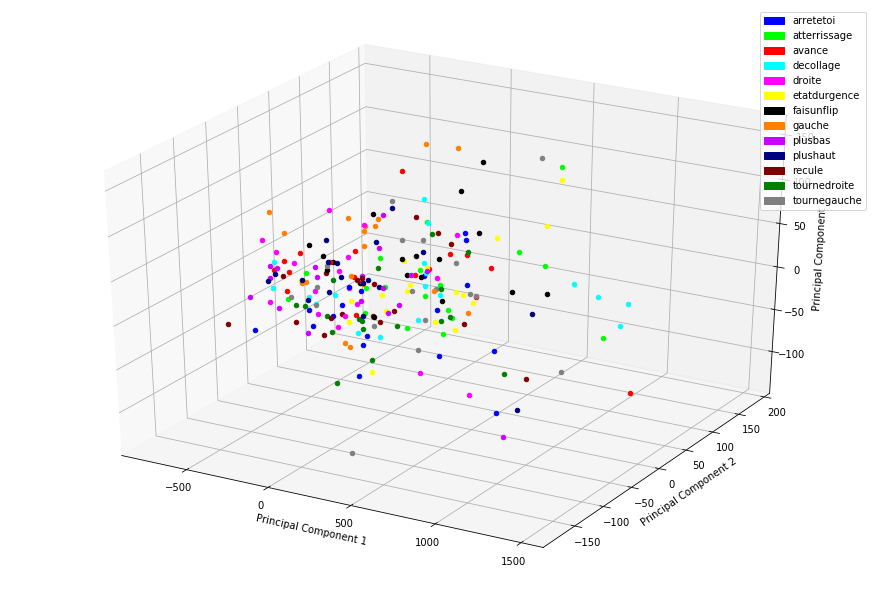

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pylab import figure
import matplotlib.patches as mpatches

n = 3 # 3 plus grandes valeurs propres
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(DATA)
print("Pourcentage de l'utilisation des caractéristiques :")
for i in range (len(pca.explained_variance_ratio_[:3])):
  print("Valeur propre numéro",i,"caractérise",round(pca.explained_variance_ratio_[i]*100,2),"% des données.")
print("\nLes 3 valeurs propres associées sont : ")
eigval = (n-1)/n*pca.explained_variance_
print(eigval)
print("\nLes 3 vecteurs propres associés sont : ")
print(pca.components_)


def modelisation_acp(pc, target1, tpc, target2):
  fig = figure()
  ax = Axes3D(fig)

  targets = ['arretetoi','atterrissage','avance','decollage','droite','etatdurgence','faisunflip','gauche','plusbas','plushaut','recule','tournedroite','tournegauche']
  colors = [(0,0,1), (0,1,0), (1,0,0),(0,1,1),(1,0,1),(1,1,0),(0,0,0),(1,0.5,0),(0.8,0,1),(0,0,0.5),(0.5,0,0),(0,0.5,0),(0.5,0.5,0.5)]
  mape = list(zip(targets,colors))

  i = 0
  for point in pc:
    name = extract_order(target1[i])
    coul = (0,0,0)
    for t in mape:
      if (t[0] == name):
        coul = t[1]
    ax.scatter(point[0],point[1],point[2], color=coul)
    i=i+1

  i=0
  for point in tpc:
    coul = (0,0,0)
    for t in mape:
      if (t[0] == target2[i]):
        coul = t[1]
    ax.scatter(point[0],point[1],point[2], marker = 's', color=coul)
    i=i+1

  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_zlabel('Principal Component 3')

  Legend = []
  for t in mape:
    Legend.append(mpatches.Patch(color=t[1], label=t[0]))
  chartBox = ax.get_position()
  ax.set_position([chartBox.x0*2, chartBox.y0*2, chartBox.width*2, chartBox.height*2])
  plt.legend(handles=Legend)

  plt.show()

modelisation_acp(principalComponents, TARGET, [], [])

### Classification par $k$ plus proches voisins

En intelligence artificielle, la méthode des $k$ plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée $x$, la méthode des $k$ plus proches voisins consiste à prendre
en compte (de façon identique) les $k$ échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée $x$, selon une distance à définir. L'algorithme 1 associé et un exemple sont donnés par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par $k$-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si $k = 3$ (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si $k = 5$ (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.

5. Rédigez un rapport sur votre étude, vos résultats et vos commentaires/conclusions.




In [ ]:
def matrice_confusion_knn(Apprentissage ,Test):  # spécialement pour le KNN

    names = ["arretetoi","atterrissage","avance","decollage","droite","etatdurgence","faisunflip",
        "gauche", "plusbas", "plushaut", "recule", "tournedroite", "tournegauche"]

    cm = confusion_matrix(Apprentissage, Test, labels = names) #matrice de confusion basique
    #print(cm) # A de-commenter pour voir la matrice de confusion simple

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap =plt.cm.Reds)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(autoscale_on = True,
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=names, yticklabels=names,
           title="Confusion Matrix for drone's order",
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    print()
    print("Taux de réussite : ",OptiOuPasOpti(cm), "%")
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j],fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    return ax

In [ ]:
# CHARGEMENT DE TOUS LES SONS DE TESTS

DATATEST = np.zeros((len(Tests),12)) # coordonnées dans la nouvelle base 
TARGETKNN2 = []

for i in range(len(Tests)):
    y, sr = librosa.load(RepBruitage+extract_rep(Tests[i])+"/"+Tests[i])
    mfcc_test = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=12)
    vecteur = transfo(mfcc_test)  # vecteur de dimension 12
    DATATEST[i][0:12] = vecteur[0:12]
    TARGETKNN2.append(extract_order(Tests[i]))



Taux de réussite :  30.09 %


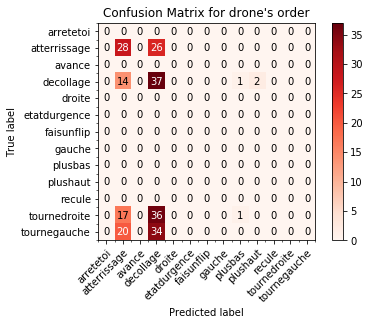

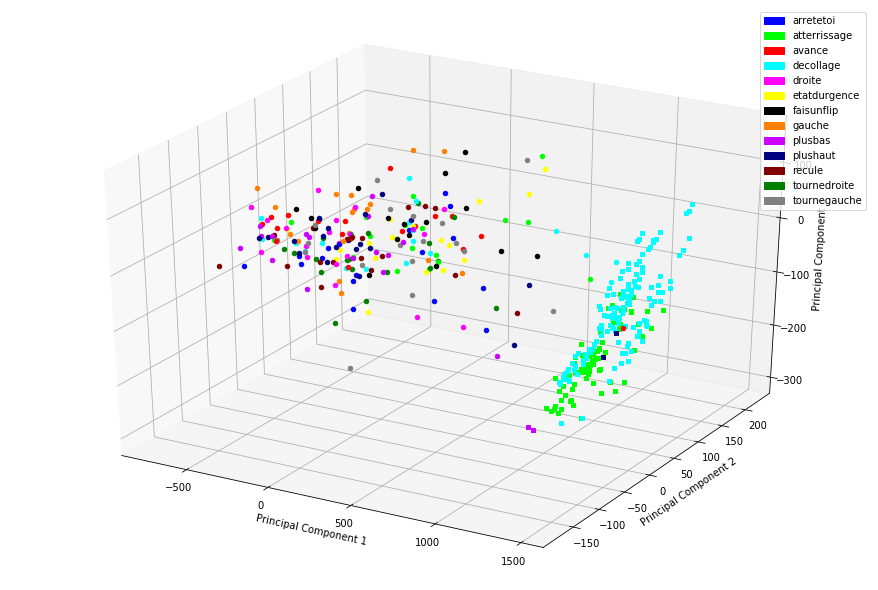

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

BASEKNN1 = principalComponents  # les coordonnées des points de la base d'apprentissage
TARGETKNN1 = TARGET
knn.fit(BASEKNN1, TARGETKNN1)  # on base les knn sur l'ensemble des points de la base d'apprentissage

# on fais le produit des composantes principales de la base d'apprentissage avec les vecteurs 12x1 des nos sons de tests
BASEKNN2 = np.dot(DATATEST,pca.components_.T)
Prediction = knn.predict(BASEKNN2)
Predict = []
for label in Prediction:
  Predict.append(extract_order(label))
matrice_confusion_knn(TARGETKNN2, Predict)
modelisation_acp(BASEKNN1, TARGETKNN1, BASEKNN2, Predict)
print()